In [3]:
import gym
import d4rl # Import required to register environments
# import time 
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
class TensorPairDataset(Dataset):
    def __init__(self, tensor1, tensor2):
        assert len(tensor1) == len(tensor2), "Tensors must have the same length"
        self.tensor1 = tensor1
        self.tensor2 = tensor2

    def __len__(self):
        return len(self.tensor1)

    def __getitem__(self, idx):
        return self.tensor1[idx], self.tensor2[idx]

In [6]:
env = gym.make("hopper-expert-v0")
dataset = env.get_dataset()

load datafile: 100%|██████████████████████████████| 5/5 [00:00<00:00, 20.21it/s]


In [7]:
len(dataset['observations'])

1000000

In [8]:
data_array = np.array(dataset["rewards"][:10000])
neg_array = data_array[data_array<0]
neg_array.size

0

In [9]:
observations = torch.tensor(dataset['observations'])[:10000]
mean = observations.mean(dim=0)
std = observations.std(dim=0)
observations = (observations - mean)/std
actions = torch.tensor(dataset['actions'])[:10000]
data = TensorPairDataset(observations,actions)

In [10]:
observations

tensor([[-0.7744,  0.7826,  2.3278,  ...,  0.0355,  0.0036, -0.0113],
        [-0.7768,  0.8052,  2.3472,  ...,  0.2680, -0.2564,  0.1914],
        [-0.7831,  0.7728,  2.3604,  ...,  0.1356, -0.6247,  0.2166],
        ...,
        [ 1.3501, -0.4600,  0.7185,  ..., -0.8782,  0.6239,  1.1158],
        [ 1.3850, -0.5587,  0.6150,  ..., -1.5694,  0.8177,  1.1408],
        [ 1.4168, -0.6333,  0.5020,  ..., -1.1095,  1.2184,  1.2135]])

In [11]:
dataset["rewards"][:10000]

array([1.0022607, 0.9360265, 0.875334 , ..., 3.9473813, 4.018456 ,
       4.088552 ], dtype=float32)

In [12]:
env.reset()

array([ 1.25065395e+00,  5.15322098e-04,  2.56907556e-03,  1.12065679e-03,
       -2.75406998e-03,  3.37945536e-03, -9.39735721e-04, -1.46458999e-03,
       -3.55131583e-03,  2.91269958e-03, -3.50517417e-03])

In [13]:
train_ds, test_ds = random_split(data,[9000,1000])


In [14]:
batch_size=128

In [15]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, 2*batch_size, num_workers=4, pin_memory=True)

In [16]:
def accuracy(loss):
    return torch.exp(-loss)

In [17]:
def normalize(input):
    mean = input.mean(dim=0)
    std = input.std(dim=0)
    input = (input - mean)/std
    return input

class Normalize(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        mean = input.mean(dim=0)
        std = input.std(dim=0)
        input = (input - mean)/std
        return input        

In [172]:
class B_Network(nn.Module):
    def __init__(self,input_size,output_size):
        super().__init__()
        self.network = nn.Sequential(nn.Linear(input_size,64),
                                     nn.ReLU(),
                                     nn.BatchNorm1d(64),
                                     nn.Linear(64,24),
                                     nn.ReLU(),
                                     nn.BatchNorm1d(24),
                                     nn.Linear(24,output_size),
                                     nn.Tanh())
    def forward(self,state):
            return self.network(state)
    
    def training_step(self, batch):
        state, action = batch 
        out = self(state)                  # Generate predictions
        loss = F.mse_loss(out, action) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        state, action = batch 
        out = self(state)                    # Generate predictions
        loss = F.mse_loss(out, action)   # Calculate loss
        acc = accuracy(loss)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [173]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [174]:
device = get_default_device()
device

device(type='cuda')

In [175]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [176]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [177]:
train_loader = DeviceDataLoader(train_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [178]:
len(train_loader)

71

In [208]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, max_lr, model, train_loader, val_loader,weight_decay=0,grad_clip=None, opt_func=torch.optim.Adam):
    """Train the model using gradient descent"""
    
    history = []
    optimizer = opt_func(model.parameters(), max_lr)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            sched.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [209]:
# Model (on GPU)
model = B_Network(11,3)

to_device(model, device)

B_Network(
  (network): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=24, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=24, out_features=3, bias=True)
    (7): Tanh()
  )
)

In [210]:
to_device(model, device)

B_Network(
  (network): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=24, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=24, out_features=3, bias=True)
    (7): Tanh()
  )
)

In [211]:
observations
model.train()

B_Network(
  (network): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=24, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=24, out_features=3, bias=True)
    (7): Tanh()
  )
)

In [212]:
history = [evaluate(model, train_loader)]
history

[{'val_loss': 0.5960399508476257, 'val_acc': 0.5512480735778809}]

In [213]:
grad_clip = 0.01
weight_decay = 0.0005
max_lr=(batch_size/32.)*0.01
epochs=200

In [214]:
history += fit(epochs, 0.001, model, train_loader, test_loader,grad_clip=None,weight_decay=weight_decay)

Epoch [0], val_loss: 0.4821, val_acc: 0.6176
Epoch [1], val_loss: 0.4045, val_acc: 0.6674
Epoch [2], val_loss: 0.3485, val_acc: 0.7058
Epoch [3], val_loss: 0.3082, val_acc: 0.7348
Epoch [4], val_loss: 0.2793, val_acc: 0.7564
Epoch [5], val_loss: 0.2572, val_acc: 0.7733
Epoch [6], val_loss: 0.2396, val_acc: 0.7870
Epoch [7], val_loss: 0.2253, val_acc: 0.7983
Epoch [8], val_loss: 0.2131, val_acc: 0.8081
Epoch [9], val_loss: 0.2025, val_acc: 0.8168
Epoch [10], val_loss: 0.1930, val_acc: 0.8246
Epoch [11], val_loss: 0.1845, val_acc: 0.8316
Epoch [12], val_loss: 0.1759, val_acc: 0.8387
Epoch [13], val_loss: 0.1685, val_acc: 0.8450
Epoch [14], val_loss: 0.1627, val_acc: 0.8499
Epoch [15], val_loss: 0.1566, val_acc: 0.8551
Epoch [16], val_loss: 0.1504, val_acc: 0.8604
Epoch [17], val_loss: 0.1461, val_acc: 0.8641
Epoch [18], val_loss: 0.1422, val_acc: 0.8674
Epoch [19], val_loss: 0.1398, val_acc: 0.8695
Epoch [20], val_loss: 0.1358, val_acc: 0.8730
Epoch [21], val_loss: 0.1347, val_acc: 0.874

In [215]:
def plot_losses(history):
    train_losses = [x.get('val_acc') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    plt.show()

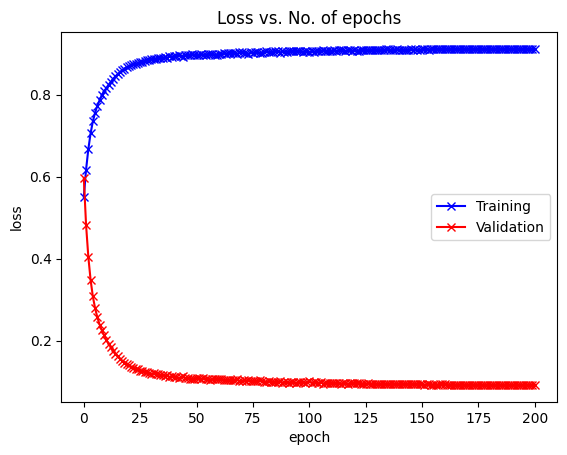

In [216]:
plot_losses(history)

In [217]:
@torch.no_grad

def test(model,episodes):
    env = gym.make("hopper-medium-v0")
    state = env.reset()
    state = torch.from_numpy(state).float().reshape(1,11)
    # print(state)
    total_reward=0
    model.eval()
    for ep in range(episodes):
        action = model(state).reshape(3)
        # print(action)
        # print(action)
        new_state, reward, done, info= env.step(action.numpy())
        # print(env.step(action))
        total_reward+=reward
        # `
        if done:
            # print(f"{ep} Total reward:",total_reward)
            break
        state = torch.from_numpy(new_state).float().reshape(1,11)
    # print(total_reward)
        # img=env.render('rgb_array')
        
    env.close()
    return total_reward

In [218]:
model.eval()

for module in model.modules():
    if isinstance(module, nn.BatchNorm1d):
        print(f"Training mode: {module.training}")

Training mode: False
Training mode: False


cpu


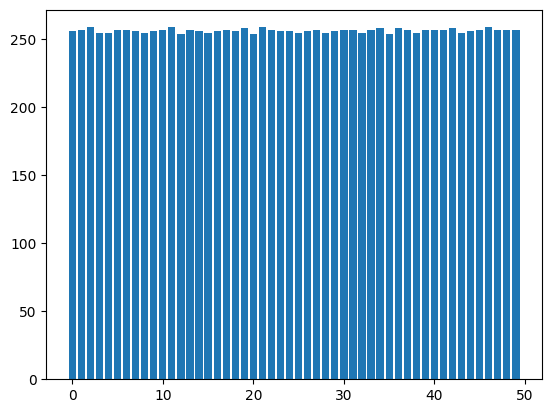

In [221]:
model.to(torch.device('cpu'))
print(next(model.parameters()).device)
test_history=[]
for i in range(50):
    # print("=====================")
    test_history.append(test(model,1000))
plt.bar(range(len(test_history)),test_history)
plt.show()

In [142]:
gym.envs.registry.all()

ValuesView(├──CartPole: [ v0, v1 ]
├──MountainCar: [ v0 ]
├──MountainCarContinuous: [ v0 ]
├──Pendulum: [ v1 ]
├──Acrobot: [ v1 ]
├──LunarLander: [ v2 ]
├──LunarLanderContinuous: [ v2 ]
├──BipedalWalker: [ v3 ]
├──BipedalWalkerHardcore: [ v3 ]
├──CarRacing: [ v1 ]
├──Blackjack: [ v1 ]
├──FrozenLake: [ v1 ]
├──FrozenLake8x8: [ v1 ]
├──CliffWalking: [ v0 ]
├──Taxi: [ v3 ]
├──Reacher: [ v2 ]
├──Pusher: [ v2 ]
├──InvertedPendulum: [ v2 ]
├──InvertedDoublePendulum: [ v2 ]
├──HalfCheetah: [ v2, v3 ]
├──Hopper: [ v2, v3 ]
├──Swimmer: [ v2, v3 ]
├──Walker2d: [ v2, v3 ]
├──Ant: [ v2, v3 ]
├──Humanoid: [ v2, v3 ]
├──HumanoidStandup: [ v2 ]
├──antmaze-umaze: [ v0, v1, v2 ]
├──antmaze-umaze-diverse: [ v0, v1, v2 ]
├──antmaze-medium-play: [ v0, v1, v2 ]
├──antmaze-medium-diverse: [ v0, v1, v2 ]
├──antmaze-large-diverse: [ v0, v1, v2 ]
├──antmaze-large-play: [ v0, v1, v2 ]
├──antmaze-eval-umaze: [ v0 ]
├──antmaze-eval-umaze-diverse: [ v0 ]
├──antmaze-eval-medium-play: [ v0 ]
├──antmaze-eval-medium-d

In [140]:
dataset["rewards"][:1000].sum()

3479.219

In [2]:
class D_Network(nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.network = nn.Sequential(nn.Linear(input_size,64),
                                     nn.Tanh(),
                                     nn.Linear(64,16),
                                     nn.Tanh(),
                                     nn.Linear(16,1),
                                     nn.Sigmoid())
    def forward(self,state,action):
        state = torch.from_numpy(state)
        action = torch.from_numpy(action)
        x = torch.cat((state, action), dim=-1)
        self.output = self.network(x)

        return self.output
    
        



NameError: name 'nn' is not defined

In [96]:
class PM_Network(nn.Module):
    def __init__(self,input_size,output_size):
        super().__init__()
        self.network_m = nn.Sequential(nn.Linear(input_size,64),
                                     nn.Tanh(),
                                     nn.Linear(64,16),
                                     nn.Tanh(),
                                     nn.Linear(16,3))                                     
        self.network_s = nn.Sequential(nn.Linear(input_size,64),
                                     nn.Tanh(),
                                     nn.Linear(64,16),
                                     nn.Tanh(),
                                     nn.Linear(16,3))      
    def forward(self,state):
        self.mean = self.network_m(state)
        self.std = torch.exp(self.network_s(state))
        normal_dist = torch.distributions.Normal(self.mean,self.std)
        raw_action = normal_dist.rsample()  # Use reparameterization trick
        
        # Map action to [-1, 1] using tanh
        action = torch.clamp(raw_action,min=-1,max=1)
        print(self.mean,self.std)
        # Compute log probability of the sampled action
        log_prob = normal_dist.log_prob(raw_action) 
        # print(log_prob)
        log_prob = log_prob.sum(dim=-1, keepdim=True)  # Sum over action dimensions
        print(action)
        
        return action, log_prob
        
                             
        # return self.output
                             
                             
    # def sample_action(self,state):
    #      # Sample from Gaussian distribution
    #     self.forward(state)
        
    #     normal_dist = torch.distributions.Normal(self.mean,self.std)
    #     raw_action = normal_dist.rsample()  # Use reparameterization trick
        
    #     # Map action to [-1, 1] using tanh
    #     action = torch.clamp(raw_action,min=-1,max=1)
    #     print(self.mean,self.std)
    #     # Compute log probability of the sampled action
    #     log_prob = normal_dist.log_prob(raw_action) 
    #     # print(log_prob)
    #     log_prob = log_prob.sum(dim=-1, keepdim=True)  # Sum over action dimensions
    #     print(action)
        
    #     return action, log_prob
        
            
        
                    
           

In [97]:
Policy = P_Network(11,3)

In [98]:
Discriminator = D_Network(14)

In [99]:
state = torch.from_numpy(env.reset())

In [101]:
Policy(state.float())

tensor([ 0.0481,  0.1880, -0.1466], grad_fn=<ViewBackward0>) tensor([1.1044, 1.1057, 0.8646], grad_fn=<ExpBackward0>)
tensor([-0.0656,  0.0516,  1.0000], grad_fn=<ClampBackward1>)


(tensor([-0.0656,  0.0516,  1.0000], grad_fn=<ClampBackward1>),
 tensor([-3.7471], grad_fn=<SumBackward1>))

In [94]:
import random

In [104]:

def train(dataset,epochs,P_network):
    state = torch.from_numpy(env.reset())
    expert_trajectories =[]
    for t in range(traj_no):
        idx = random.randint(0,len(dataset)-max_steps)
        expert_trajectories.append(dataset[idx:idx+max_steps])

    for epoch in range(epochs):
        
        for path in range(traj_no):

            aD_loss = 0
            eD_loss = 0
            state = torch.from_numpy(env.reset())
            for step in range(max_steps):
                action, log_prob = P_network(state)
                next_state,reward,done,info = env.step(numpy.array(action))
                
                exp_state = expert_trajectories[path]["observations"][step]
                exp_action = expert_trajectories[path]["actions"][step]
                
                aD_loss += torch.log(D_network(state,action))
                eD_loss += torch.log(1- D_network(exp_state,exp_action))

                if done:
                    eD_loss /= step
                    aD_loss /= step
                    

                                                  
    
                
                
                
    
    
    

SyntaxError: incomplete input (2281725345.py, line 28)

In [77]:
dataset

{'actions': array([[ 0.8259195 , -0.43341178,  0.8120992 ],
        [ 0.8244549 , -0.7164865 ,  0.07432321],
        [ 0.8499072 , -0.20028582,  0.13544567],
        ...,
        [ 0.308399  , -0.28698418,  0.7205197 ],
        [ 0.30791777,  0.00762309, -0.5651019 ],
        [-0.32234538,  0.23280619, -0.63004637]], dtype=float32),
 'observations': array([[ 1.2508533e+00,  1.6305586e-03, -7.9514465e-04, ...,
          1.4964999e-03,  1.6224863e-03, -4.4636223e-03],
        [ 1.2504431e+00,  3.1245863e-03,  2.3545863e-03, ...,
          3.9008829e-01, -6.6784775e-01,  1.1991799e+00],
        [ 1.2493614e+00,  9.8507630e-04,  4.5010685e-03, ...,
          1.6879366e-01, -1.6157442e+00,  1.3486822e+00],
        ...,
        [ 1.6186366e+00, -9.1755435e-02, -4.5169634e-01, ...,
         -2.7762216e-01,  1.4225568e+00,  1.0000000e+01],
        [ 1.6156299e+00, -9.0178706e-02, -4.5196101e-01, ...,
          2.0981342e-01,  1.2374721e+00,  6.4053802e+00],
        [ 1.6133553e+00, -8.5746430e